In [ ]:
import os
import cv2
import shutil
import random
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, cohen_kappa_score
from keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from keras import optimizers, applications
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, Callback, LearningRateScheduler
from keras.layers import Dense, Dropout, GlobalAveragePooling2D, Input

# Set seeds to make the experiment more reproducible.
import tensorflow
def seed_everything(seed=0):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    tensorflow.random.set_seed(0)
    # set_random_seed(0)
seed = 0
seed_everything(seed)

%matplotlib inline
sns.set(style="whitegrid")
warnings.filterwarnings("ignore")

In [ ]:
from google.colab import drive

drive.mount('/content/drive', force_remount=True)
path = '/content/drive/My Drive/Colab Notebooks/aptos2019-blindness-detection/'


Mounted at /content/drive


In [ ]:
train = pd.read_csv(path+'train.csv')
test = pd.read_csv(path+'test.csv')
print('Number of train samples: ', train.shape[0])
print('Number of test samples: ', test.shape[0])

# Preprocecss data
train["id_code"] = train["id_code"].apply(lambda x: x + ".png")
test["id_code"] = test["id_code"].apply(lambda x: x + ".png")
train['diagnosis'] = train['diagnosis'].astype('str')
display(train.head())

Number of train samples:  3662
Number of test samples:  1928


,id_code,diagnosis
0,000c1434d8d7.png,2
1,001639a390f0.png,4
2,0024cdab0c1e.png,1
3,002c21358ce6.png,0
4,005b95c28852.png,0


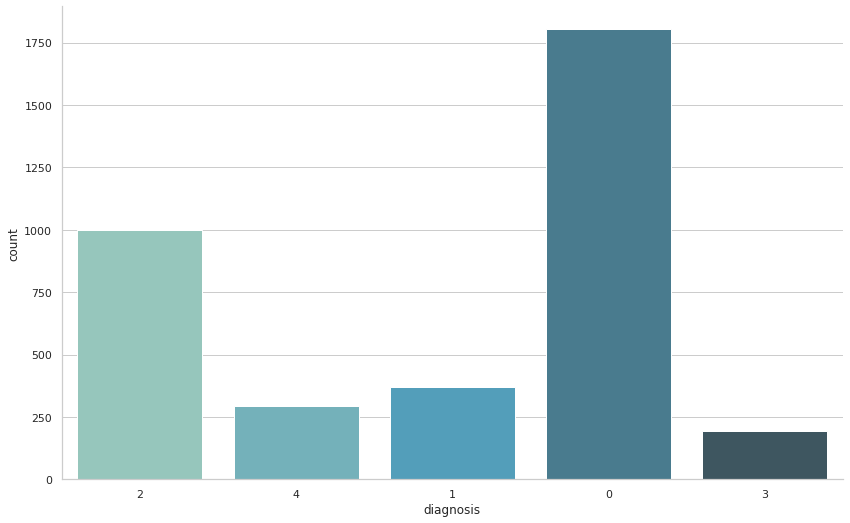

In [ ]:
f, ax = plt.subplots(figsize=(14, 8.7))
ax = sns.countplot(x="diagnosis", data=train, palette="GnBu_d")
sns.despine()
plt.show()

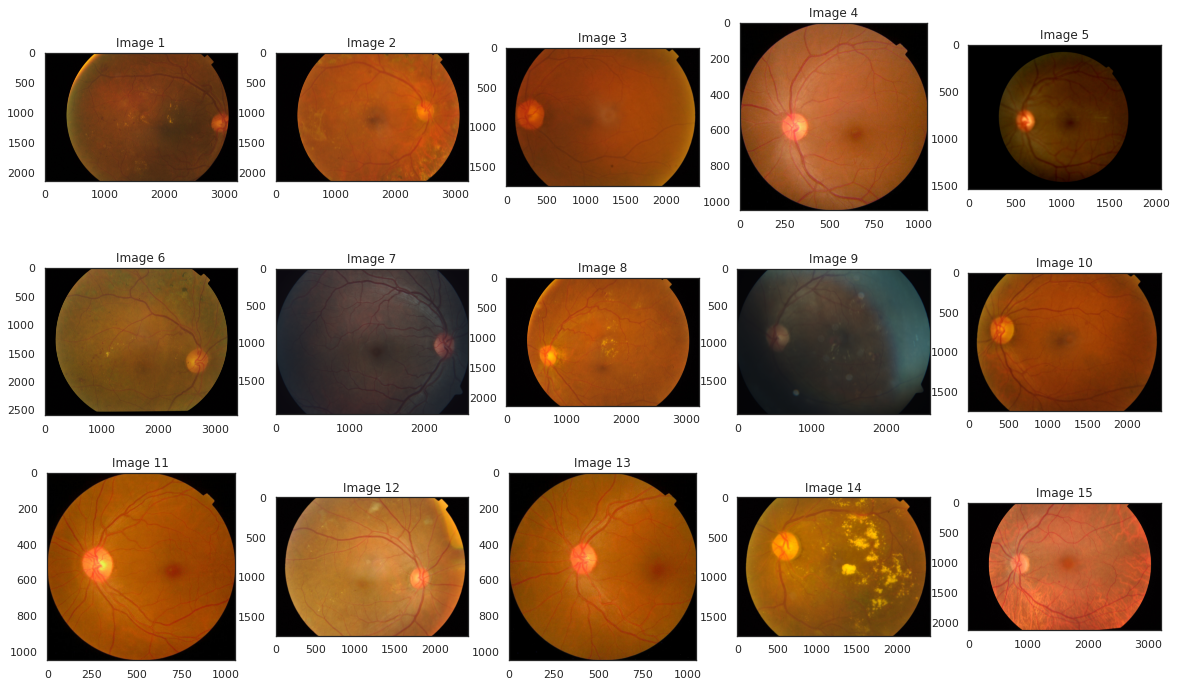

In [ ]:
sns.set_style("white")
count = 1
plt.figure(figsize=[20, 20])
for img_name in train["id_code"][:15]:
    img = cv2.imread("/content/drive/My Drive/Colab Notebooks/aptos2019-blindness-detection/train_images/%s" % img_name)[...,[2, 1, 0]]
    plt.subplot(5, 5, count)
    plt.imshow(img)
    plt.title("Image %s" % count)
    count += 1

plt.show()

In [ ]:
# Model parameters
BATCH_SIZE = 8
EPOCHS = 20
WARMUP_EPOCHS = 2
LEARNING_RATE = 1e-4
WARMUP_LEARNING_RATE = 1e-3
HEIGHT = 728
WIDTH = 728
CANAL = 3
N_CLASSES = train['diagnosis'].nunique()
ES_PATIENCE = 5
RLROP_PATIENCE = 3
DECAY_DROP = 0.5

In [ ]:
train_datagen=ImageDataGenerator(rescale=1./255,
                                 validation_split=0.2,
                                 horizontal_flip=True)

train_generator=train_datagen.flow_from_dataframe(
    dataframe=train,
    directory=path+"train_images",
    x_col="id_code",
    y_col="diagnosis",
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    target_size=(HEIGHT, WIDTH),
    subset='training')

valid_generator=train_datagen.flow_from_dataframe(
    dataframe=train,
    directory=path+"train_images",
    x_col="id_code",
    y_col="diagnosis",
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    target_size=(HEIGHT, WIDTH),
    subset='validation')

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_dataframe(
        dataframe=test,
        directory = path+"test_images",
        x_col="id_code",
        target_size=(HEIGHT, WIDTH),
        batch_size=1,
        shuffle=False,
        class_mode=None)

Found 2930 validated image filenames belonging to 5 classes.
Found 732 validated image filenames belonging to 5 classes.
Found 1928 validated image filenames.


In [ ]:
def create_model(input_shape, n_out):
    input_tensor = Input(shape=input_shape)
    base_model = tensorflow.keras.applications.ResNet50(weights='imagenet',
                                       include_top=False,
                                       input_tensor=input_tensor)

    x = GlobalAveragePooling2D()(base_model.output)
    x = Dropout(0.5)(x)
    x = Dense(2048, activation='relu')(x)
    x = Dropout(0.5)(x)
    final_output = Dense(n_out, activation='softmax', name='final_output')(x)
    model = Model(input_tensor, final_output)

    return model

In [ ]:
model = create_model(input_shape=(HEIGHT, WIDTH, CANAL), n_out=N_CLASSES)

for layer in model.layers:
    layer.trainable = False

for i in range(-5, 0):
    model.layers[i].trainable = True

metric_list = ["accuracy"]
optimizer = tensorflow.keras.optimizers.Adam(lr=WARMUP_LEARNING_RATE)
model.compile(optimizer=optimizer, loss="categorical_crossentropy",  metrics=metric_list)
model.summary()

94781440/94765736 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 728, 728, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 734, 734, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 364, 364, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                             

In [ ]:
STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = valid_generator.n//valid_generator.batch_size

history_warmup = model.fit_generator(generator=train_generator,
                                     steps_per_epoch=10,
                                     validation_data=valid_generator,
                                     validation_steps=30,
                                     epochs=10,
                                     verbose=1).history


Epoch 1/10
10/10 [==============================] - 174s 17s/step - loss: 4.6672 - accuracy: 0.3375 - val_loss: 2.9782 - val_accuracy: 0.4542
Epoch 2/10
10/10 [==============================] - 133s 14s/step - loss: 5.6259 - accuracy: 0.3250 - val_loss: 4.6048 - val_accuracy: 0.0875
Epoch 3/10
10/10 [==============================] - 108s 12s/step - loss: 5.1075 - accuracy: 0.4375 - val_loss: 6.0028 - val_accuracy: 0.1250
Epoch 4/10
10/10 [==============================] - 91s 10s/step - loss: 7.3074 - accuracy: 0.3500 - val_loss: 4.9412 - val_accuracy: 0.0875
Epoch 5/10
10/10 [==============================] - 87s 9s/step - loss: 5.9631 - accuracy: 0.2625 - val_loss: 5.0495 - val_accuracy: 0.4458
Epoch 6/10
10/10 [==============================] - 80s 8s/step - loss: 6.0426 - accuracy: 0.4125 - val_loss: 6.0387 - val_accuracy: 0.2875
Epoch 7/10
10/10 [==============================] - 72s 8s/step - loss: 5.3484 - accuracy: 0.2625 - val_loss: 3.9419 - val_accuracy: 0.4792
Epoch 8/10
10

In [ ]:
for layer in model.layers:
    layer.trainable = True

es = EarlyStopping(monitor='val_loss', mode='min', patience=ES_PATIENCE, restore_best_weights=True, verbose=1)
rlrop = ReduceLROnPlateau(monitor='val_loss', mode='min', patience=RLROP_PATIENCE, factor=DECAY_DROP, min_lr=1e-6, verbose=1)

callback_list = [es, rlrop]
optimizer = tensorflow.keras.optimizers.Adam(lr=LEARNING_RATE)
model.compile(optimizer=optimizer, loss="categorical_crossentropy",  metrics=metric_list)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 728, 728, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 734, 734, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 364, 364, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [ ]:
history_finetunning = model.fit_generator(generator=train_generator,
                                          steps_per_epoch=10,
                                          validation_data=valid_generator,
                                          validation_steps=30,
                                          epochs=10,
                                          callbacks=callback_list,
                                          verbose=1).history

Epoch 1/10
10/10 [==============================] - 76s 7s/step - loss: 1.4701 - accuracy: 0.5500 - val_loss: 7.5274 - val_accuracy: 0.5042 - lr: 1.0000e-04
Epoch 2/10
10/10 [==============================] - 65s 7s/step - loss: 1.3271 - accuracy: 0.5375 - val_loss: 6.0618 - val_accuracy: 0.4625 - lr: 1.0000e-04
Epoch 3/10
10/10 [==============================] - 64s 7s/step - loss: 0.9069 - accuracy: 0.6625 - val_loss: 1.8403 - val_accuracy: 0.4875 - lr: 1.0000e-04
Epoch 4/10
10/10 [==============================] - 61s 6s/step - loss: 0.6788 - accuracy: 0.7500 - val_loss: 3.6749 - val_accuracy: 0.4625 - lr: 1.0000e-04
Epoch 5/10
10/10 [==============================] - 75s 8s/step - loss: 0.9521 - accuracy: 0.7125 - val_loss: 8.9874 - val_accuracy: 0.4542 - lr: 1.0000e-04
Epoch 6/10
10/10 [==============================] - ETA: 0s - loss: 1.0262 - accuracy: 0.7000
Epoch 6: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
10/10 [==============================] - 60s 

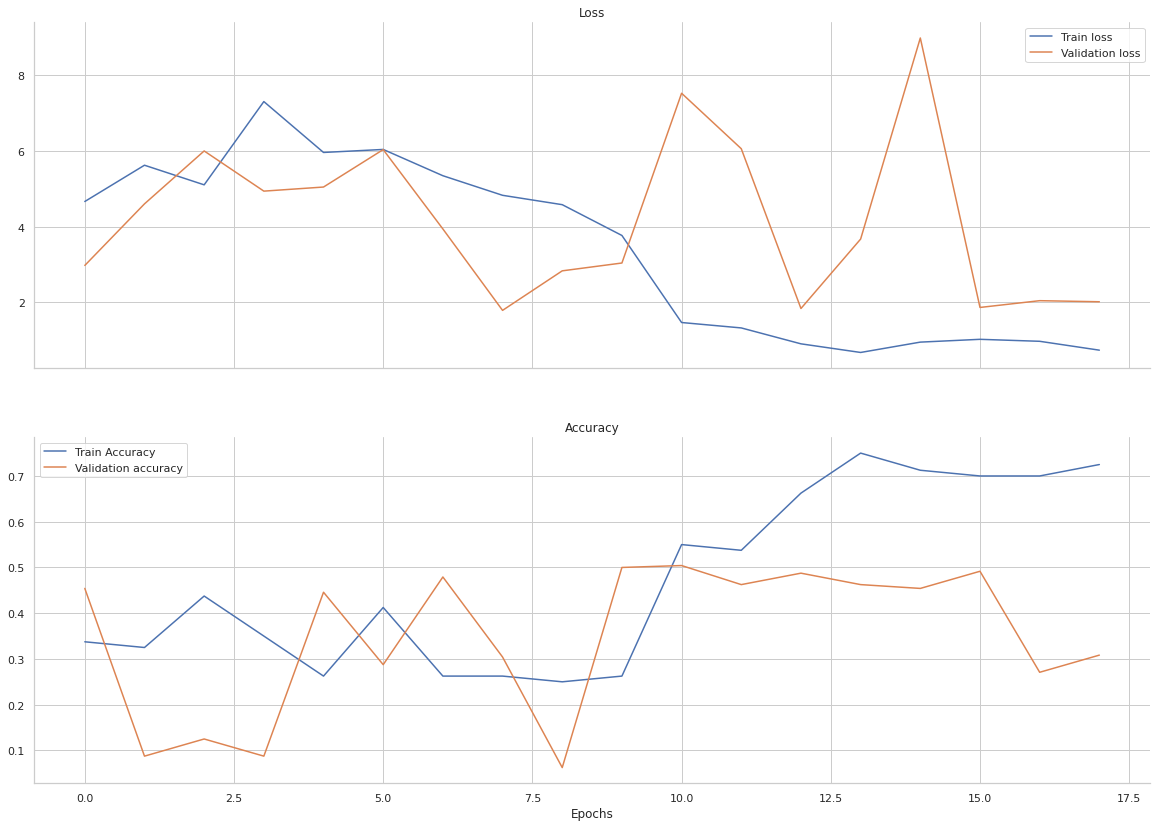

In [ ]:
history = {'loss': history_warmup['loss'] + history_finetunning['loss'],
           'val_loss': history_warmup['val_loss'] + history_finetunning['val_loss'],
           'accuracy': history_warmup['accuracy'] + history_finetunning['accuracy'],
           'val_accuracy': history_warmup['val_accuracy'] + history_finetunning['val_accuracy']}

sns.set_style("whitegrid")
fig, (ax1, ax2) = plt.subplots(2, 1, sharex='col', figsize=(20, 14))

ax1.plot(history['loss'], label='Train loss')
ax1.plot(history['val_loss'], label='Validation loss')
ax1.legend(loc='best')
ax1.set_title('Loss')

ax2.plot(history['accuracy'], label='Train Accuracy')
ax2.plot(history['val_accuracy'], label='Validation accuracy')
ax2.legend(loc='best')
ax2.set_title('Accuracy')

plt.xlabel('Epochs')
sns.despine()
plt.show()

In [ ]:
model.save("/content/drive/My Drive/Colab Notebooks/aptos2019-blindness-detection/my_model.h5")

In [ ]:
complete_datagen = ImageDataGenerator(rescale=1./255)
complete_generator = complete_datagen.flow_from_dataframe(
        dataframe=train,
        directory = "/content/drive/My Drive/Colab Notebooks/aptos2019-blindness-detection/train_images/",
        x_col="id_code",
        target_size=(HEIGHT, WIDTH),
        batch_size=1,
        shuffle=False,
        class_mode=None)

STEP_SIZE_COMPLETE = complete_generator.n//complete_generator.batch_size
train_preds = model.predict_generator(complete_generator, steps=STEP_SIZE_COMPLETE)
train_preds = [np.argmax(pred) for pred in train_preds]

Found 3662 validated image filenames.


In [ ]:
import sklearn
print(sklearn.metrics.classification_report(train['diagnosis'].astype('int'), train_preds))

              precision    recall  f1-score   support

           0       0.49      1.00      0.66      1805
           1       0.00      0.00      0.00       370
           2       0.00      0.00      0.00       999
           3       0.00      0.00      0.00       193
           4       0.00      0.00      0.00       295

    accuracy                           0.49      3662
   macro avg       0.10      0.20      0.13      3662
weighted avg       0.24      0.49      0.33      3662



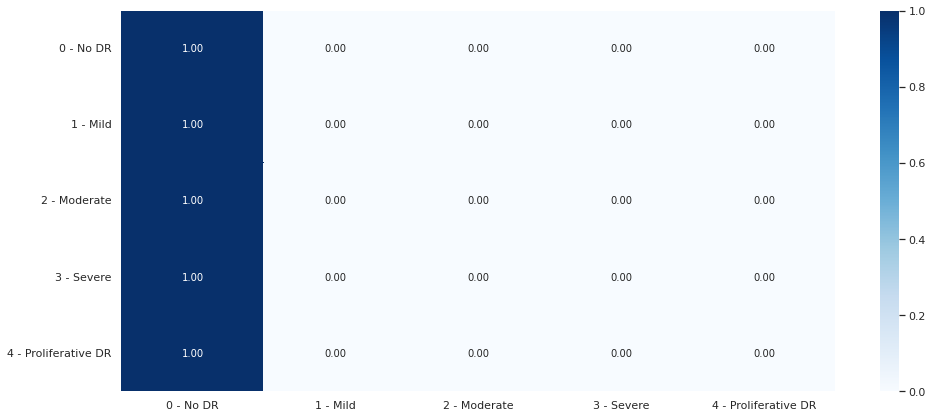

In [ ]:
labels = ['0 - No DR', '1 - Mild', '2 - Moderate', '3 - Severe', '4 - Proliferative DR']
cnf_matrix = confusion_matrix(train['diagnosis'].astype('int'), train_preds)
cnf_matrix_norm = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]
df_cm = pd.DataFrame(cnf_matrix_norm, index=labels, columns=labels)
plt.figure(figsize=(16, 7))
sns.heatmap(df_cm, annot=True, fmt='.2f', cmap="Blues")
plt.show()

In [ ]:
from keras.applications.vgg16 import VGG16
from keras.models import Sequential
from tifffile.tifffile import sequence
from keras.layers import Dense, Dropout, Flatten
VGG_MODEL = VGG16(weights = 'imagenet', include_top = False ,input_shape =(728,728,3))

for layer in VGG_MODEL.layers[:-4]:
  layer.trainable = False

model = Sequential()
model.add(VGG_MODEL)
model.add(Flatten())
model.add(Dense(256, activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(126, activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(5, activation = 'softmax'))

58900480/58889256 [==============================] - 0s 0us/step


In [ ]:
es = EarlyStopping(monitor='val_loss', mode='min', patience=ES_PATIENCE, restore_best_weights=True, verbose=1)
rlrop = ReduceLROnPlateau(monitor='val_loss', mode='min', patience=RLROP_PATIENCE, factor=DECAY_DROP, min_lr=1e-6, verbose=1)

callback_list = [es, rlrop]
optimizer = tensorflow.keras.optimizers.Adam(lr=LEARNING_RATE)
model.compile(optimizer=optimizer, loss="categorical_crossentropy",  metrics=metric_list)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 22, 22, 512)       14714688  
                                                                 
 flatten (Flatten)           (None, 247808)            0         
                                                                 
 dense_1 (Dense)             (None, 256)               63439104  
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 126)               32382     
                                                                 
 dropout_3 (Dropout)         (None, 126)               0         
                                                                 
 dense_3 (Dense)             (None, 5)                 6

In [ ]:
history_finetunning = model.fit_generator(generator=train_generator,
                                          steps_per_epoch=10,
                                          validation_data=valid_generator,
                                          validation_steps=30,
                                          epochs=10,
                                          callbacks=callback_list,
                                          verbose=1).history

Epoch 1/10
10/10 [==============================] - 61s 6s/step - loss: 1.6468 - accuracy: 0.4750 - val_loss: 0.8524 - val_accuracy: 0.7000 - lr: 1.0000e-04
Epoch 2/10
10/10 [==============================] - 52s 6s/step - loss: 1.3326 - accuracy: 0.5375 - val_loss: 1.1286 - val_accuracy: 0.5167 - lr: 1.0000e-04
Epoch 3/10
10/10 [==============================] - 51s 6s/step - loss: 1.0188 - accuracy: 0.5125 - val_loss: 0.9264 - val_accuracy: 0.6750 - lr: 1.0000e-04
Epoch 4/10
10/10 [==============================] - ETA: 0s - loss: 0.8834 - accuracy: 0.7375
Epoch 4: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
10/10 [==============================] - 49s 5s/step - loss: 0.8834 - accuracy: 0.7375 - val_loss: 0.8655 - val_accuracy: 0.7208 - lr: 1.0000e-04
Epoch 5/10
10/10 [==============================] - 54s 6s/step - loss: 0.9653 - accuracy: 0.6375 - val_loss: 0.9432 - val_accuracy: 0.6750 - lr: 5.0000e-05
Epoch 6/10
10/10 [==============================] - 52s 

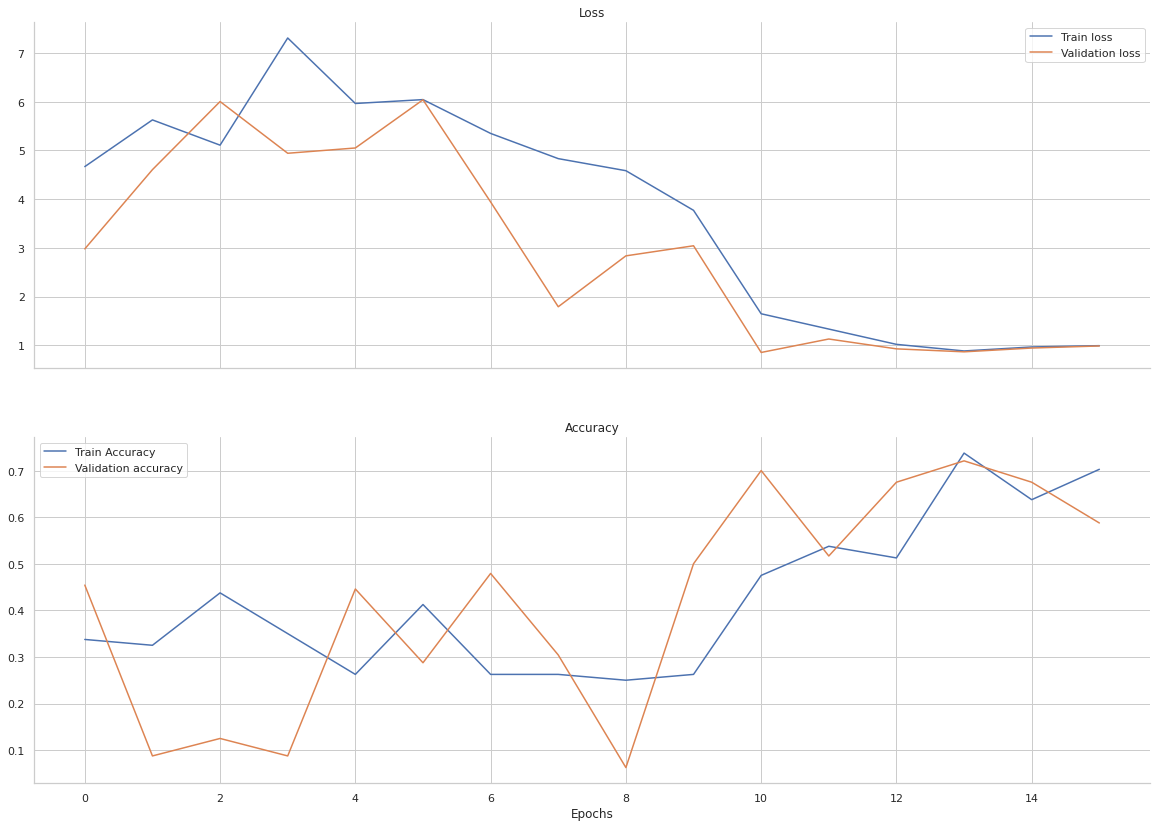

In [ ]:
history = {'loss': history_warmup['loss'] + history_finetunning['loss'],
           'val_loss': history_warmup['val_loss'] + history_finetunning['val_loss'],
           'accuracy': history_warmup['accuracy'] + history_finetunning['accuracy'],
           'val_accuracy': history_warmup['val_accuracy'] + history_finetunning['val_accuracy']}

sns.set_style("whitegrid")
fig, (ax1, ax2) = plt.subplots(2, 1, sharex='col', figsize=(20, 14))

ax1.plot(history['loss'], label='Train loss')
ax1.plot(history['val_loss'], label='Validation loss')
ax1.legend(loc='best')
ax1.set_title('Loss')

ax2.plot(history['accuracy'], label='Train Accuracy')
ax2.plot(history['val_accuracy'], label='Validation accuracy')
ax2.legend(loc='best')
ax2.set_title('Accuracy')

plt.xlabel('Epochs')
sns.despine()
plt.show()

In [ ]:
complete_datagen = ImageDataGenerator(rescale=1./255)
complete_generator = complete_datagen.flow_from_dataframe(
        dataframe=train,
        directory = "/content/drive/My Drive/Colab Notebooks/aptos2019-blindness-detection/train_images/",
        x_col="id_code",
        target_size=(HEIGHT, WIDTH),
        batch_size=1,
        shuffle=False,
        class_mode=None)

STEP_SIZE_COMPLETE = complete_generator.n//complete_generator.batch_size
train_preds = model.predict_generator(complete_generator, steps=STEP_SIZE_COMPLETE)
train_preds = [np.argmax(pred) for pred in train_preds]

Found 3662 validated image filenames.


In [ ]:
import sklearn
print(sklearn.metrics.classification_report(train['diagnosis'].astype('int'), train_preds))

              precision    recall  f1-score   support

           0       0.79      0.91      0.85      1805
           1       0.00      0.00      0.00       370
           2       0.48      0.76      0.59       999
           3       0.00      0.00      0.00       193
           4       0.00      0.00      0.00       295

    accuracy                           0.66      3662
   macro avg       0.25      0.34      0.29      3662
weighted avg       0.52      0.66      0.58      3662



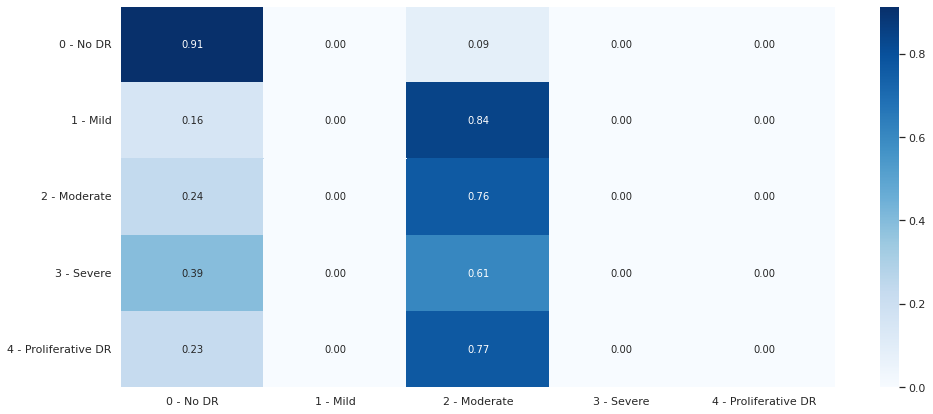

In [ ]:
labels = ['0 - No DR', '1 - Mild', '2 - Moderate', '3 - Severe', '4 - Proliferative DR']
cnf_matrix = confusion_matrix(train['diagnosis'].astype('int'), train_preds)
cnf_matrix_norm = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]
df_cm = pd.DataFrame(cnf_matrix_norm, index=labels, columns=labels)
plt.figure(figsize=(16, 7))
sns.heatmap(df_cm, annot=True, fmt='.2f', cmap="Blues")
plt.show()

In [ ]:
model.save("/content/drive/My Drive/Colab Notebooks/aptos2019-blindness-detection/my_model1.h5")

In [ ]:
from keras.applications.xception import Xception
xception = Xception(include_top=False, input_shape = (728,728,3))
for layer in xception.layers[:-4]:
  layer.trainable = False

model = Sequential()
model.add(xception)
model.add(Flatten())
model.add(Dense(256, activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(126, activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(5, activation = 'softmax'))

83697664/83683744 [==============================] - 0s 0us/step


In [ ]:
import tensorflow as tf


In [ ]:
es = EarlyStopping(monitor='val_loss', mode='min', patience=ES_PATIENCE, restore_best_weights=True, verbose=1)
rlrop = ReduceLROnPlateau(monitor='val_loss', mode='min', patience=RLROP_PATIENCE, factor=DECAY_DROP, min_lr=1e-6, verbose=1)

callback_list = [es, rlrop]
optimizer = tf.optimizers.Adam(lr=LEARNING_RATE)
model.compile(optimizer=optimizer, loss="categorical_crossentropy",  metrics=metric_list)
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 23, 23, 2048)      20861480  
                                                                 
 flatten_1 (Flatten)         (None, 1083392)           0         
                                                                 
 dense_4 (Dense)             (None, 256)               277348608 
                                                                 
 dropout_4 (Dropout)         (None, 256)               0         
                                                                 
 dense_5 (Dense)             (None, 126)               32382     
                                                                 
 dropout_5 (Dropout)         (None, 126)               0         
                                                                 
 dense_6 (Dense)             (None, 5)                

In [ ]:
history_finetunning = model.fit_generator(generator=train_generator,
                                          steps_per_epoch=10,
                                          validation_data=valid_generator,
                                          validation_steps=30,
                                          epochs=10,
                                          callbacks=callback_list,
                                          verbose=1).history

Epoch 1/10
10/10 [==============================] - 82s 8s/step - loss: 7.8600 - accuracy: 0.4250 - val_loss: 3.4795 - val_accuracy: 0.6500 - lr: 1.0000e-04
Epoch 2/10
10/10 [==============================] - 71s 8s/step - loss: 8.2676 - accuracy: 0.5125 - val_loss: 2.1632 - val_accuracy: 0.6917 - lr: 1.0000e-04
Epoch 3/10
10/10 [==============================] - 93s 10s/step - loss: 6.1107 - accuracy: 0.5625 - val_loss: 2.3437 - val_accuracy: 0.6208 - lr: 1.0000e-04
Epoch 4/10
10/10 [==============================] - 55s 6s/step - loss: 5.2257 - accuracy: 0.5625 - val_loss: 2.2118 - val_accuracy: 0.6875 - lr: 1.0000e-04
Epoch 5/10
10/10 [==============================] - 57s 6s/step - loss: 3.6667 - accuracy: 0.6125 - val_loss: 1.6559 - val_accuracy: 0.6250 - lr: 1.0000e-04
Epoch 6/10
10/10 [==============================] - 54s 6s/step - loss: 5.3774 - accuracy: 0.5000 - val_loss: 1.4746 - val_accuracy: 0.7250 - lr: 1.0000e-04
Epoch 7/10
10/10 [==============================] - 55s 6

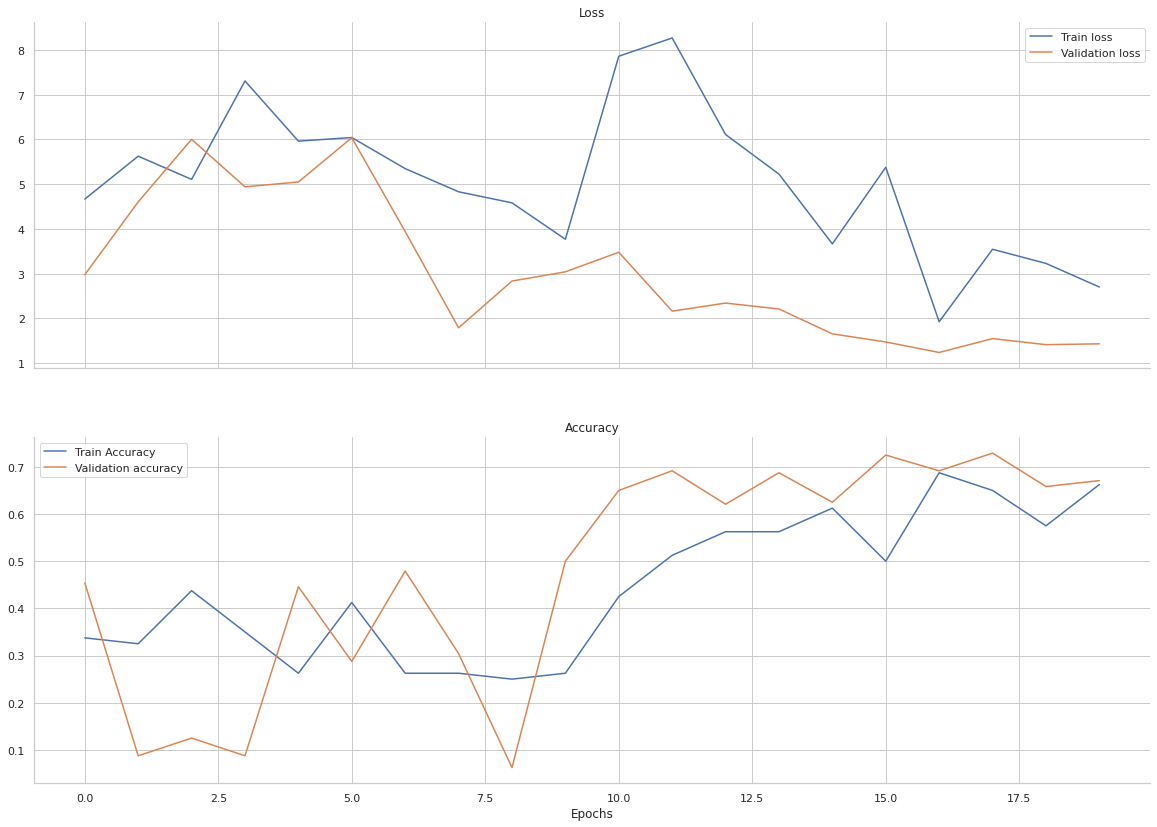

In [ ]:
history = {'loss': history_warmup['loss'] + history_finetunning['loss'],
           'val_loss': history_warmup['val_loss'] + history_finetunning['val_loss'],
           'accuracy': history_warmup['accuracy'] + history_finetunning['accuracy'],
           'val_accuracy': history_warmup['val_accuracy'] + history_finetunning['val_accuracy']}

sns.set_style("whitegrid")
fig, (ax1, ax2) = plt.subplots(2, 1, sharex='col', figsize=(20, 14))

ax1.plot(history['loss'], label='Train loss')
ax1.plot(history['val_loss'], label='Validation loss')
ax1.legend(loc='best')
ax1.set_title('Loss')

ax2.plot(history['accuracy'], label='Train Accuracy')
ax2.plot(history['val_accuracy'], label='Validation accuracy')
ax2.legend(loc='best')
ax2.set_title('Accuracy')

plt.xlabel('Epochs')
sns.despine()
plt.show()

In [ ]:
model.save("/content/drive/My Drive/Colab Notebooks/aptos2019-blindness-detection/my_model2.h5")

In [ ]:
complete_datagen = ImageDataGenerator(rescale=1./255)
complete_generator = complete_datagen.flow_from_dataframe(
        dataframe=train,
        directory = "/content/drive/My Drive/Colab Notebooks/aptos2019-blindness-detection/train_images/",
        x_col="id_code",
        target_size=(HEIGHT, WIDTH),
        batch_size=1,
        shuffle=False,
        class_mode=None)

STEP_SIZE_COMPLETE = complete_generator.n//complete_generator.batch_size
train_preds = model.predict_generator(complete_generator, steps=STEP_SIZE_COMPLETE)
train_preds = [np.argmax(pred) for pred in train_preds]

Found 3662 validated image filenames.


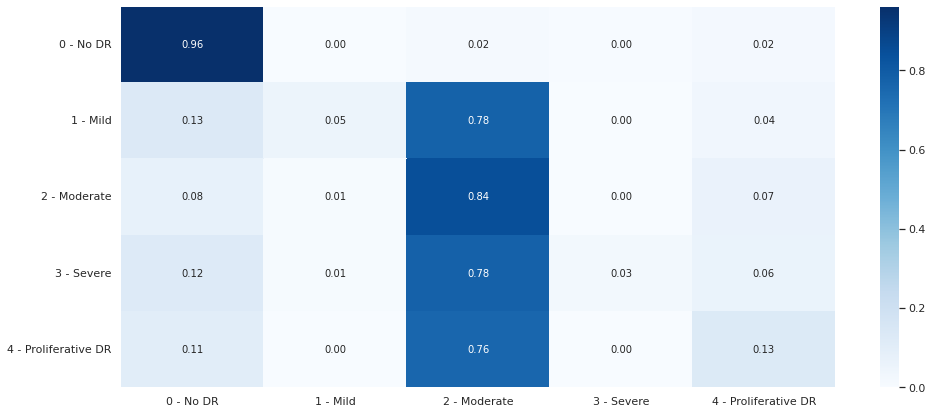

In [ ]:
labels = ['0 - No DR', '1 - Mild', '2 - Moderate', '3 - Severe', '4 - Proliferative DR']
cnf_matrix = confusion_matrix(train['diagnosis'].astype('int'), train_preds)
cnf_matrix_norm = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]
df_cm = pd.DataFrame(cnf_matrix_norm, index=labels, columns=labels)
plt.figure(figsize=(16, 7))
sns.heatmap(df_cm, annot=True, fmt='.2f', cmap="Blues")
plt.show()

In [ ]:
print("Train Cohen Kappa score: %.3f" % cohen_kappa_score(train_preds, train['diagnosis'].astype('int'), weights='quadratic'))

Train Cohen Kappa score: 0.680


In [ ]:
test_generator.reset()
STEP_SIZE_TEST = test_generator.n//test_generator.batch_size
preds = model.predict_generator(test_generator, steps=STEP_SIZE_TEST,verbose =1)
predictions = [np.argmax(pred) for pred in preds]

1928/1928 [==============================] - 639s 332ms/step


In [ ]:
filenames = test_generator.filenames
results = pd.DataFrame({'id_code':filenames, 'diagnosis':predictions})
results['id_code'] = results['id_code'].map(lambda x: str(x)[:-4])
results.to_csv('/content/drive/My Drive/Colab Notebooks/aptos2019-blindness-detection/submission.csv',index=False)


In [ ]:
from google.colab import files
files.download('/content/drive/My Drive/Colab Notebooks/aptos2019-blindness-detection/submission.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

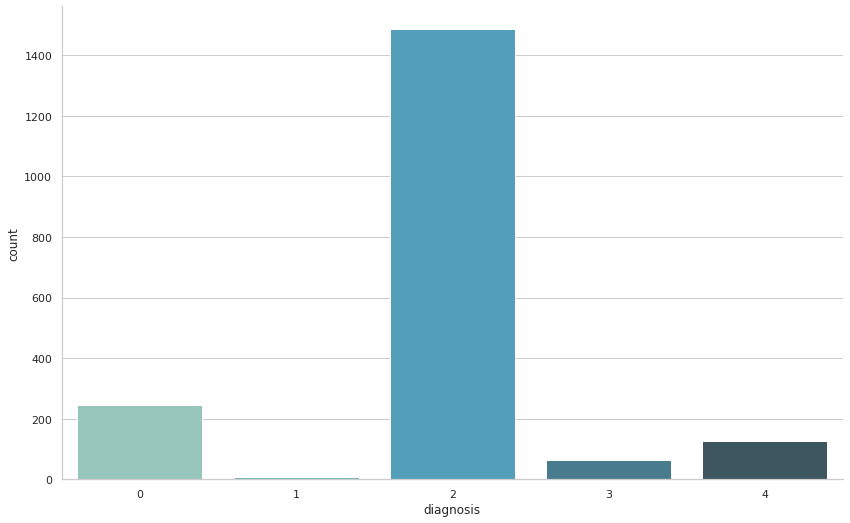

In [ ]:
f, ax = plt.subplots(figsize=(14, 8.7))
ax = sns.countplot(x="diagnosis", data=results, palette="GnBu_d")
sns.despine()
plt.show()

In [ ]:
from keras import models
my_model = models.load_model("/content/drive/My Drive/Colab Notebooks/aptos2019-blindness-detection/my_model2.h5")

In [ ]:
import sklearn
print(sklearn.metrics.classification_report(train['diagnosis'].astype('int'), train_preds))

              precision    recall  f1-score   support

           0       0.90      0.96      0.93      1805
           1       0.62      0.05      0.10       370
           2       0.55      0.84      0.67       999
           3       0.29      0.03      0.05       193
           4       0.23      0.13      0.17       295

    accuracy                           0.72      3662
   macro avg       0.52      0.40      0.38      3662
weighted avg       0.69      0.72      0.67      3662

